This is a test experimental extraction using a black 0.2mm 3-d printed sample. 
I'm using Theo's Code and my Newton-Raphson algorithm. My main goal is to first extract the 
value of the complex refractive index, n, of the given material, first using NR, and then try to utilize Bayesian and ADAM optimizers to extract realistic material parameters. 

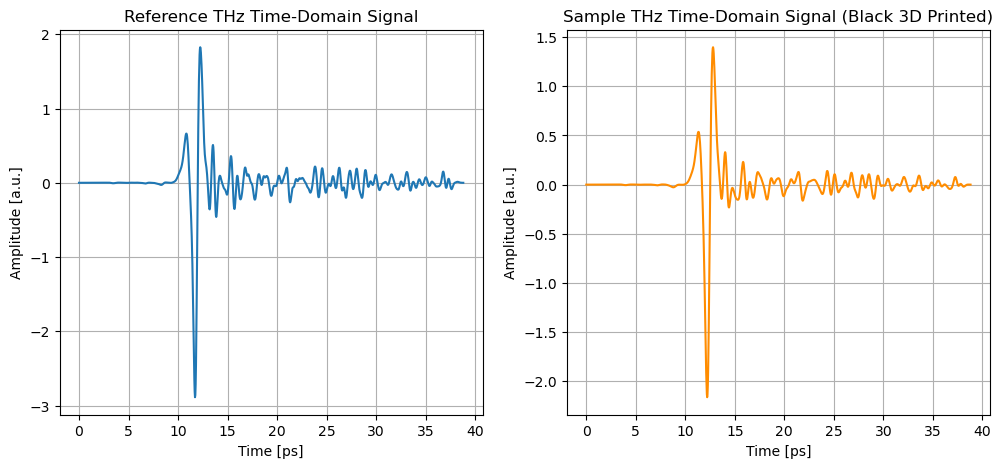

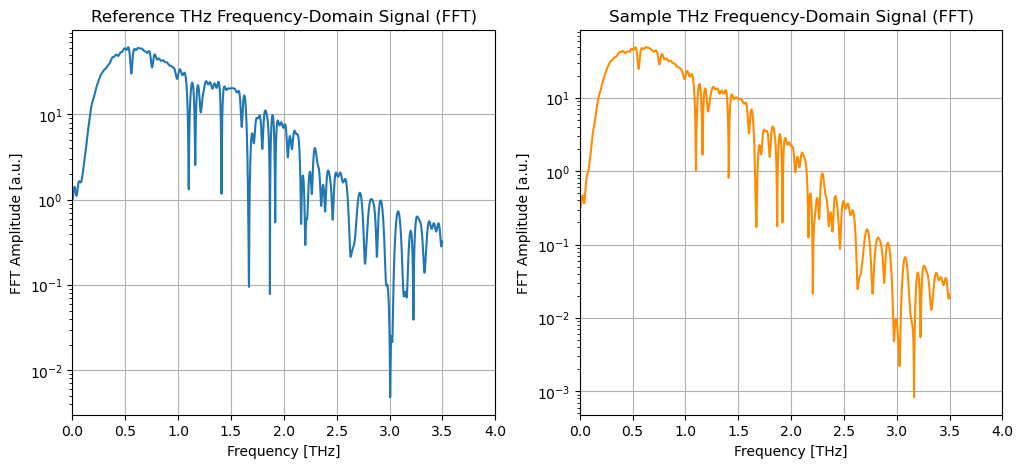

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd

# Move up one directory from the notebook location
notebook_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add that directory to sys.path if not already present
if notebook_root not in sys.path:
    sys.path.insert(0, notebook_root)



# INSERT REFERENCE DATA 
reference_pulse = np.loadtxt(r"C:\miniconda_projects\repository\TerahertzProject\TheoTHzTDS\THz-TDS\Transfer Matrix Method\data\Ref2.txt",dtype=float)

# INSERT SAMPLE DATA
sample_pulse_black_2mm = np.loadtxt(r"C:\miniconda_projects\repository\TerahertzProject\TheoTHzTDS\THz-TDS\Transfer Matrix Method\data\Sample_black_3dprint.txt",dtype=float)

t1= reference_pulse[:,0] + 733.8  # ADJUISTING THE AXIS
amp1 = reference_pulse[:,1]
t2 = sample_pulse_black_2mm[:,0] + 733.8  # ADJUISTING THE AXIS
amp2 = sample_pulse_black_2mm[:,1]

# FFT OF SIGNALS
reference_fft = np.fft.fft(amp1,16384)
sample_fft = np.fft.fft(amp2,16384)

time_step = t1[1] - t1[0]
frequency = np.fft.fftfreq(16384, d=time_step*1e-12)  # Convert ps to s for frequency calculation


# MASK
mask = (frequency > 0) & (frequency < 3.5 * 10**12)
reference_fft = reference_fft[mask]
sample_fft = sample_fft[mask]
frequency = frequency[mask]



# PLOTTING REFERENCE AND SAMPLE SIGNALS


# PLOTS
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(t1,amp1)
plt.xlabel('Time [ps]')
plt.ylabel('Amplitude [a.u.]')
plt.title('Reference THz Time-Domain Signal')
plt.grid()  
plt.subplot(1,2,2)
plt.plot(t2,amp2, color='darkorange')
plt.xlabel('Time [ps]')
plt.ylabel('Amplitude [a.u.]')
plt.title('Sample THz Time-Domain Signal (Black 3D Printed)')
plt.grid()
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(frequency*1e-12,np.abs(reference_fft))
plt.xlim(0,4)
plt.yscale('log')
plt.xlabel('Frequency [THz]')
plt.ylabel('FFT Amplitude [a.u.]')
plt.title('Reference THz Frequency-Domain Signal (FFT)')
plt.grid()
plt.subplot(1,2,2)
plt.plot(frequency*1e-12,np.abs(sample_fft), color='darkorange')
plt.xlim(0,4)
plt.yscale('log')
plt.xlabel('Frequency [THz]')
plt.ylabel('FFT Amplitude [a.u.]')
plt.title('Sample THz Frequency-Domain Signal (FFT)')
plt.grid()
plt.show()


Time delay (ps):  0.5608843499999239
Average refractive index:  1.8413265249998858


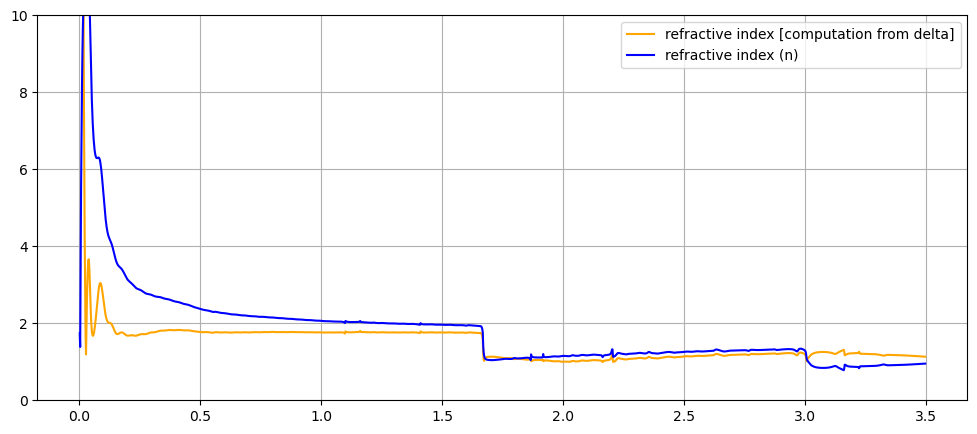

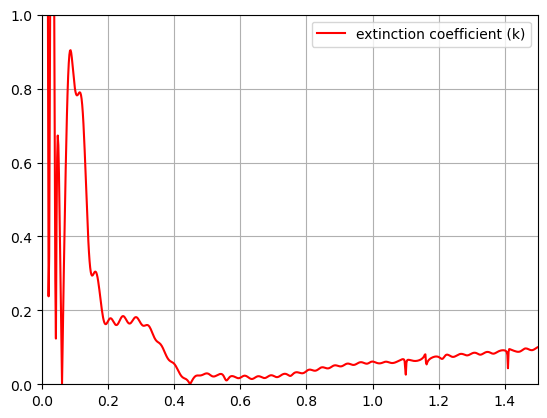

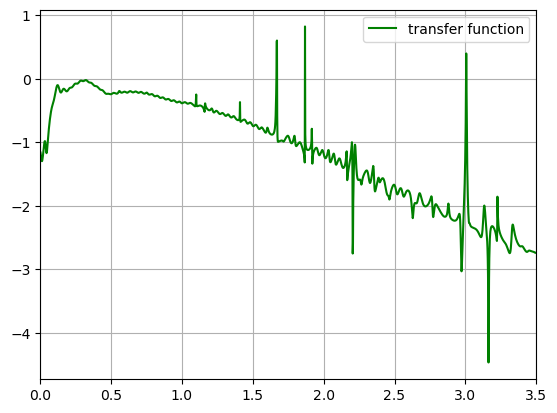

Mean refractive index (n):  1.8380497067100363


In [2]:
# PHASE UNWRAPPING 
uwrapped_ref = np.unwrap(np.angle(reference_fft))
uwrapped_sample = np.unwrap(np.angle(sample_fft))
delta = uwrapped_sample - uwrapped_ref


# TIME DELAY BETWEEN SIGNALS CALCULATION

max_reference_signal = np.max(amp1)
point_in_time_ref = t1[amp1.argmax()]
max_sample_signal = np.max(amp2)
point_in_time_sample = t2[amp2.argmax()]

dt = np.abs(  (point_in_time_sample) -  (point_in_time_ref) ) #time delay in ps
print("Time delay (ps): ", dt)


# REFRACTIVE INDEX CALCULATION

frequency[frequency == 0] = 1e-12  # Replace zeros with a small value to avoid division by zero
c = 3e8 #speed of light in m/s
d = 0.2e-3 #thickness of sample in m
n_0 = 1  # Refractive index of air

navg = 1 + (c * dt*1e-12) / d
print("Average refractive index: ", navg)


# TRANSFER FUNCTION CALCULATION

transfer_signal = sample_fft / reference_fft
transfer_phase = np.angle(transfer_signal)
tphase_unwrapped = np.unwrap(transfer_phase)
tphase_unwrapped -= tphase_unwrapped[0]-0.5*np.pi
ln_transfer = np.log(np.abs(transfer_signal) + 1e-12) + 1j * tphase_unwrapped


refractive = 1 + (np.abs(delta)* c) / (2 * np.pi * frequency * d)

# NEWTON RAPHSON METHOD
def G_zero(n, f, ln_exp):

    ln_th =np.log((4  * n) / (1+ n)**2)-(1j *( 2*np.pi*f) * d / c) * (n - n_0)
    return  ln_th - ln_exp

def G_zerod(n, f):
    p = 1 / n
    m =  2 / (n + n_0) + (1j *(2*np.pi* f) * d) / c 
    return p - m 

def new_raph(n_1, ln_exp, f, iterations, tol):
    n = n_1
    for i in range(iterations): 
        G_zero_ = G_zero(n,  f, ln_exp)
        G_zerod_ = G_zerod(n, f)
        dn = G_zero_ / G_zerod_
        n = n - dn
        if abs(G_zero_/G_zerod_) < tol:
           # print(i, "iterations")
            break
    return n


# INITIAL GUESS AND CALCULATION
n_1 = 2 + 0.05j
n_ = []

for i, f in enumerate(frequency, 0):
    ln_exp = np.log(np.abs(transfer_signal[i])) + 1j * tphase_unwrapped[i]
    n_values = new_raph( n_1 ,ln_exp, f,  iterations=70, tol=1e-10)
    n_.append(n_values)


# print("Refractive index values:", n_)
n_ = np.array(n_) 


# PLOTTING REFRACTIVE INDEX AND TRANSFER FUNCTION

plt.figure(figsize=(12,5))
plt.plot(frequency*1e-12, refractive, label='Refractive Index [computation from delta]', color='orange')
plt.plot(frequency*1e-12, abs(n_.real), label='Refractive Index (n)', color='blue')
#plt.xlim(xmax = 3.5, xmin = 0)
plt.ylim(ymin=0, ymax=10)
plt.legend(["refractive index [computation from delta]", "refractive index (n)"])
plt.grid(True)
plt.show()


plt.plot(frequency*1e-12, np.abs(n_.imag), label='Extinction Coefficient (k)', color='red')
plt.xlim(xmax = 1.5, xmin = 0)
plt.ylim(0,1)
plt.legend(["extinction coefficient (k)"])
plt.grid(True)
plt.show()

plt.plot(frequency*1e-12, np.log(np.abs(transfer_signal)), label='Transfer Function Amplitude', color='green')
plt.xlim(xmax = 3.5, xmin = 0)
plt.legend(["transfer function"])
plt.grid(True)
plt.show()  

mean_n = np.mean(n_.real)
print("Mean refractive index (n): ", mean_n)

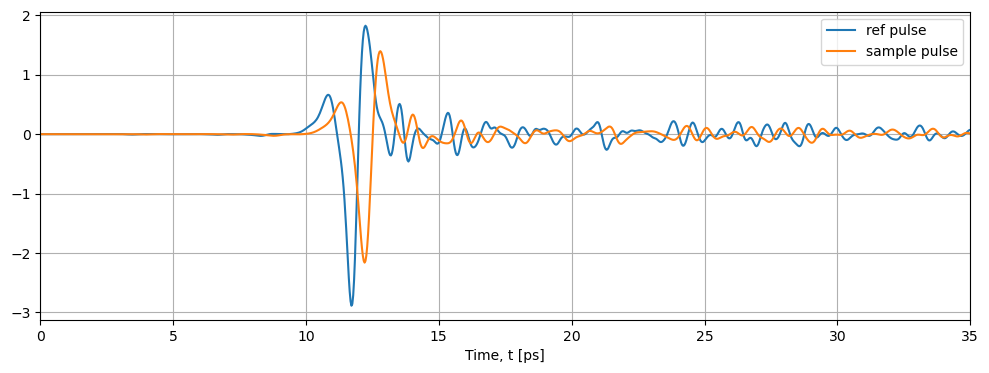

In [3]:
import torch
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor
from Matrix_methods.AdamExtractor import LayeredExtractor
from Matrix_methods.Simulate import simulate_parallel

# BAYES AND ADAM EXTRACTION

# CONVERT DATA TO TENSORS

# REFERENCE PULSE
reference_pulse_tensor = torch.tensor(amp1, dtype=torch.float32)
#SAMPLE PULSE
sample_pulse_tensor = torch.tensor(amp2, dtype=torch.float32)


plt.figure(figsize=(12,4))
plt.plot(t1, reference_pulse_tensor.detach().cpu().numpy(),label='ref pulse')
plt.plot(t2, sample_pulse_tensor.detach().cpu().numpy(),label='sample pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.xlim(0,35)
plt.grid()
plt.show()

In [4]:
deltat = np.diff(t1)[0]
print(f"The difference between the two points of the time axis is: {deltat} picoseconds")


deltat = deltat * 1e-12  # Convert ps to s for calculations

The difference between the two points of the time axis is: 0.03299319999996442 picoseconds


Delta t:  3.299319999996442e-14
Number of time points, L:  1177
Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (1.53, 2.13)
Layer 1 - k ∈ (-0.013000000000000001, 0.007)
Layer 1 - D ∈ (0.00019050000000000002, 0.0002095)
[((1.7363708421108939-0.013000000000000001j), 0.0002095)]


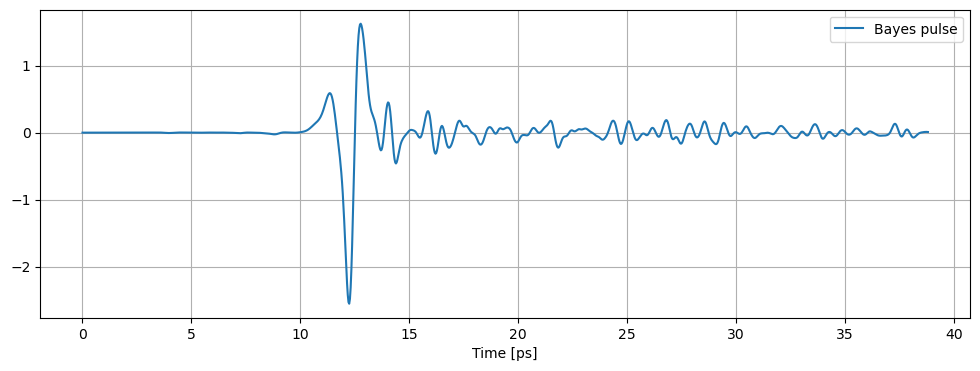

Fine-tuning 3 parameters for 300 iterations.
Iteration 49, Loss: 5.047102e-02, Layer 0: n=1.7326, k=-0.01798, D=210.59 µm
Iteration 99, Loss: 4.606898e-02, Layer 0: n=1.7285, k=-0.02286, D=211.80 µm
Iteration 149, Loss: 4.191774e-02, Layer 0: n=1.7241, k=-0.02763, D=213.10 µm
Iteration 199, Loss: 3.805167e-02, Layer 0: n=1.7195, k=-0.03226, D=214.46 µm
Iteration 249, Loss: 3.451581e-02, Layer 0: n=1.7149, k=-0.03672, D=215.86 µm
Iteration 299, Loss: 3.136311e-02, Layer 0: n=1.7103, k=-0.04095, D=217.29 µm
[((1.7102558612823486-0.04095424711704254j), 0.0002172869280911982)]


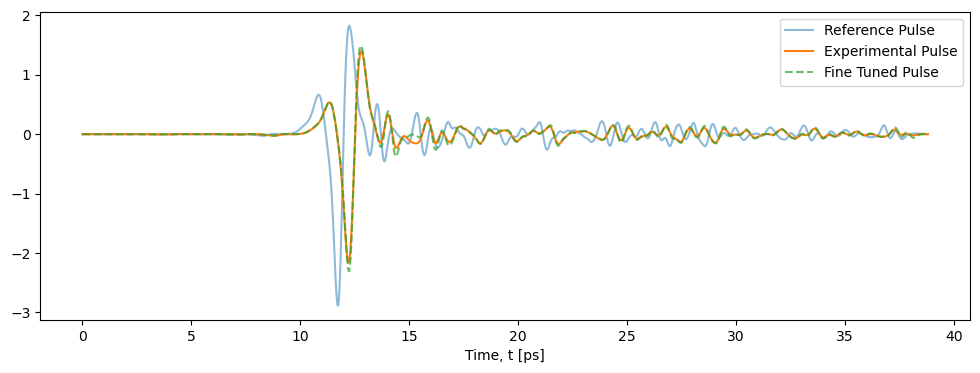

In [5]:
# INITIAL GUESSES FOR BAYESIAN OPTIMIZATION
layers_init = [(1.83-0.003j, 0.2e-3)] 

optimization_bounds = [0.3, 0.01, 9.5e-6]
L = len(reference_pulse)


print("Delta t: ", deltat)
print("Number of time points, L: ", L)

# MASKS
optimization_mask = [(True, True, True)]

# INITIALIZE EXTRACTOR FOR THE DATA
Bayes_extractor = BayesianLayeredExtractor(reference_pulse_tensor,sample_pulse_tensor, deltat, layers_init,optimization_mask, optimization_bounds=optimization_bounds)

# EXTRACTION LOOP AND PARAMETERS
bayes_params = Bayes_extractor.bayesian_optimization(n_calls=50)




# RUN FORWARD PASS WITH GEOFF’S MODEL
bayes_pulse = simulate_parallel(reference_pulse_tensor,bayes_params, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

 # BAYESIAN PARAMETERS
print(bayes_params)

 # BAYESIAN PULSE
plt.figure(figsize=(12,4))
plt.plot(t1, bayes_pulse, label='Bayes pulse', linestyle='-')
plt.xlabel('Time [ps]')
plt.grid(True)
plt.legend()
plt.show()







 # ADAM OPTIMIZERS INITIALIZATION
grad_optimizer = LayeredExtractor(reference_pulse_tensor,sample_pulse_tensor, deltat, bayes_params,optimization_mask, lr=0.0001)
 # Run optimization for set iterations, ‘updates’ provides a printout of progress
optim_params = grad_optimizer.optimize(num_iterations=300,updates=50)
optim_pulse = simulate_parallel(reference_pulse_tensor,
optim_params, deltat, 0)[1].detach().cpu().numpy()[:L]
print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(t1, reference_pulse_tensor.detach().cpu().numpy(), label='Reference Pulse',
alpha=0.5)
plt.plot(t2, sample_pulse_tensor.detach().cpu().numpy(),
label='Experimental Pulse')
plt.plot(t1, optim_pulse, label='Fine Tuned Pulse',alpha=0.7, linestyle='--')
plt.xlabel('Time, t [ps]')
plt.legend() 
plt.show()

Fine-tuning 3 parameters for 300 iterations.
Iteration 49, Loss: 5.047102e-02, Layer 0: n=1.7326, k=-0.01798, D=210.59 µm
Iteration 99, Loss: 4.606898e-02, Layer 0: n=1.7285, k=-0.02286, D=211.80 µm
Iteration 149, Loss: 4.191774e-02, Layer 0: n=1.7241, k=-0.02763, D=213.10 µm
Iteration 199, Loss: 3.805167e-02, Layer 0: n=1.7195, k=-0.03226, D=214.46 µm
Iteration 249, Loss: 3.451581e-02, Layer 0: n=1.7149, k=-0.03672, D=215.86 µm
Iteration 299, Loss: 3.136311e-02, Layer 0: n=1.7103, k=-0.04095, D=217.29 µm
[((1.7102558612823486-0.04095424711704254j), 0.0002172869280911982)]


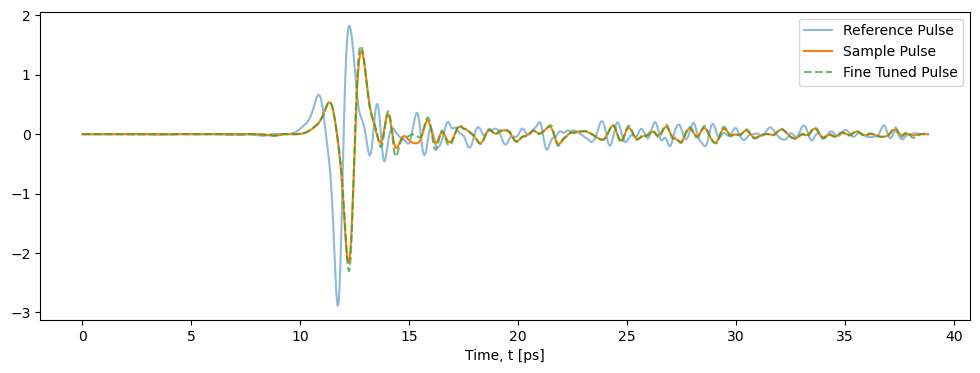

In [6]:
 # Initialize adam optimizer object
grad_optimizer = LayeredExtractor(reference_pulse_tensor,
 sample_pulse_tensor, deltat, bayes_params,
 optimization_mask, lr=0.0001)
 # Run optimization for set iterations, ‘updates’ provides a printout of progress

optim_params = grad_optimizer.optimize(num_iterations=300,updates=50)
optim_pulse = simulate_parallel(reference_pulse_tensor,optim_params, deltat, 0)[1].detach().cpu().numpy()[:L]
print(optim_params)


plt.figure(figsize=(12,4))
plt.plot(t1, reference_pulse_tensor.detach().cpu().numpy(), label='Reference Pulse',
 alpha=0.5)
plt.plot(t2, sample_pulse_tensor.detach().cpu().numpy(),
label='Sample Pulse')
plt.plot(t2, optim_pulse, label='Fine Tuned Pulse',alpha=0.7, linestyle='--')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

In [7]:
print("The final parameters given by the extraction are:")
print(optim_params)

The final parameters given by the extraction are:
[((1.7102558612823486-0.04095424711704254j), 0.0002172869280911982)]


In [8]:
# CALCULATE THE PERCENTGE ERROR BETWEEN THE OPTIMIZED AND MY PARAMERTERS

my_n = navg
opt_n = optim_params[0][0]

my_d = 0.2e-3 # thickness in m
opt_m = optim_params[0][1]


percentage_error_n = abs((opt_n - my_n) / my_n) * 100
percentage_error_m = abs((opt_m - my_d) / my_d) * 100

print(f"Percentage error in refractive index: {percentage_error_n:.2f}%")
print(f"Percentage error in thickness: {percentage_error_m:.2f}%")

Percentage error in refractive index: 7.46%
Percentage error in thickness: 8.64%
